# SPEEDY Atmosphere (Fortran)

Here we setup, run and plot a fast atmospheric model called [speedy.f90](https://github.com/samhatfield/speedy.f90)
which stands for _Simplified Parameterizations, privitivE-Equation DYnamics_. Documentation can be found
[here](https://samhatfield.co.uk/speedy.f90/) and [here](https://www.ictp.it/research/esp/models/speedy.aspx).

In [1]:
using ClimateModels, Pkg, Plots, NetCDF
using Suppressor, OrderedCollections, Git, UUIDs

import ClimateModels: build, setup, launch

## Define Model Interface

In [2]:
"""
    struct SPEEDY_config <: AbstractModelConfig

Concrete type of `AbstractModelConfig` for `SPEEDY` model.
"""
Base.@kwdef struct SPEEDY_config <: AbstractModelConfig
    model :: String = "speedy"
    configuration :: String = "default"
    options :: OrderedDict{Any,Any} = OrderedDict{Any,Any}()
    inputs :: OrderedDict{Any,Any} = OrderedDict{Any,Any}()
    outputs :: OrderedDict{Any,Any} = OrderedDict{Any,Any}()
    status :: OrderedDict{Any,Any} = OrderedDict{Any,Any}()
    channel :: Channel{Any} = Channel{Any}(10)
    folder :: String = tempdir()
    ID :: UUID = UUIDs.uuid4()
end

function setup(x :: SPEEDY_config)
    !isdir(joinpath(x.folder)) ? mkdir(joinpath(x.folder)) : nothing
    pth=joinpath(x.folder,string(x.ID))
    !isdir(pth) ? mkdir(pth) : nothing

    url="https://github.com/gaelforget/speedy.f90"
    @suppress run(`$(git()) clone -b more_diags $url $pth`)

    !isdir(joinpath(pth,"log")) ? git_log_init(x) : nothing

    put!(x.channel,launch)
end

function build(x :: SPEEDY_config)
    pth0=pwd()
    pth=joinpath(x.folder,string(x.ID))

    cd(pth)
    if Sys.isapple()
        ENV["NETCDF"] = "/usr/local/Cellar/netcdf/4.8.0_1/" #may differ between computers
    else
        ENV["NETCDF"] = "/usr/" #may differ between computers
    end
    @suppress run(`bash build.sh`)
    cd(pth0)
end

function launch(x::SPEEDY_config)
    pth0=pwd()
    pth=joinpath(x.folder,string(x.ID))
    cd(pth)
    @suppress run(`bash run.sh`)
    cd(pth0)
end

launch (generic function with 2 methods)

## Setup, Build, And Launch

In [3]:
MC=SPEEDY_config()
setup(MC)
build(MC)
launch(MC)

## Read Model Output And Plot

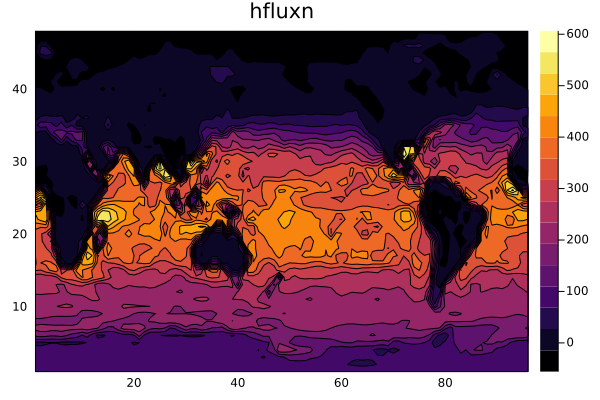

In [4]:
function plot(x::SPEEDY_config,varname="hfluxn")
    pth=joinpath(MC.folder,string(MC.ID))
    ncfile = NetCDF.open(joinpath(pth,"rundir","198201072200.nc"))
    tmp = ncfile.vars[varname][:,:,1,1]
    contourf(tmp', frmt=:png,title=varname)
end

plot(MC,"hfluxn")

## Model Parameters

In [5]:
import MITgcmTools: read_namelist
p=dirname(pathof(ClimateModels))
include(joinpath(p,"../examples/helper_functions.jl"))

nml=read_namelist(MC)
nml[:params]

OrderedCollections.OrderedDict{Any, Any} with 2 entries:
  "nsteps_out " => 1
  "nstdia     " => 180

## Time Steps, etc

In [6]:
nml[:date]

OrderedCollections.OrderedDict{Any, Any} with 10 entries:
  "start_datetime%year   " => 1982
  "start_datetime%month  " => 1
  "start_datetime%day    " => 1
  "start_datetime%hour   " => 0
  "start_datetime%minute " => 0
  "end_datetime%year     " => 1982
  "end_datetime%month    " => 1
  "end_datetime%day      " => 10
  "end_datetime%hour     " => 0
  "end_datetime%minute   " => 0

---

*This notebook was generated using [Literate.jl](https://github.com/fredrikekre/Literate.jl).*